# Preamble

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:0.23.23`
import $ivy.`org.http4s::http4s-dsl:0.23.23`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import cats.effect.{IO, Async}
import cats.effect.unsafe.implicits.global
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
def stream[F[_]: cats.effect.kernel.Async](u: org.http4s.Uri): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, bearerToken))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
extension [A](st: Stream[IO, A])
    def run: List[A] = 
        st.compile.toList.unsafeRunSync()

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
object IsObject: 
    def unapply(v: Json): Option[JsonObject] = 
        v.asObject

In [ ]:
object IsString: 
    def unapply(v: Json): Option[String] = 
        v.asString

In [ ]:
def allCommitPages[F[_]: Async](repo: String): Stream[F, Json] =

    def newPage(i: Int): Stream[F, Json] = 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"))
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

# How to embed `jq`? 

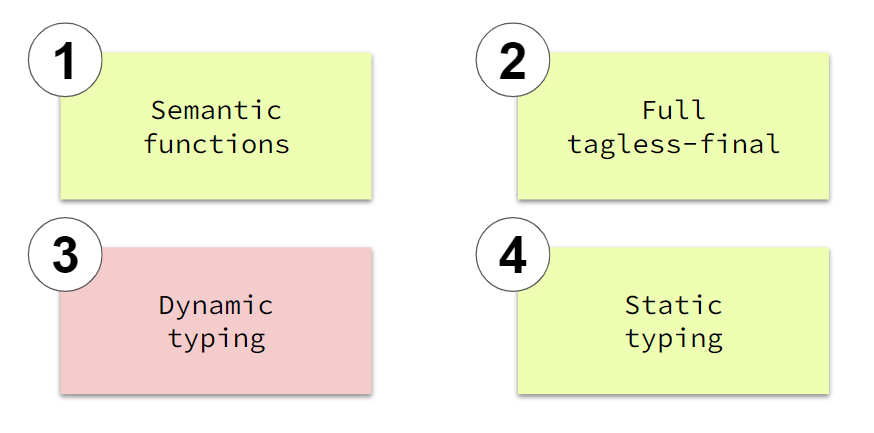

### Errors in `jq`

The following program `.[]` will generate an error at runtime when faced with non-arrays. [Try it!](https://jqplay.org/s/glmK1_9ucMr)

Try-catch example.

### Type-class update 

In [ ]:
trait Jq[R]: 

    /* Primitive Filters */

    def id: R
    def str(s: String): R
    def iterator: R
    def array(f: R): R
    def error(msg: String): R
    
    extension (f1: R)
        def |(f2: R): R
        def concat(f2: R): R
        def index(f2: R): R
        def `catch`(f2: R): R

    /* built-in functions */

    def map(f: R): R = 
        array(iterator | f)

object Jq: 

    def apply[R](using J: Jq[R]): Jq[R] = J

    object syntax: 
        def id[R](using J: Jq[R]): R = J.id 
        def str[R](using J: Jq[R])(s: String): R = J.str(s)
        def iterator[R](using J: Jq[R]): R = J.iterator
        def error[R](msg: String)(using J: Jq[R]): R = J.error(msg)

        def arr[R](f: R*)(using J: Jq[R]): R = 
            J.array(f.reduce(_ concat _))

        extension [R](sc: StringContext)(using J: Jq[R])
            def i(args: R*): R = 
                sc.s().split('.').toList.map(key => J.id.index(J.str(key))).reduce(_ | _)

    enum Error: 
        case CannotIterateOver(j: Json)
        case CannotIndexObjectWith(j: Json)
        case CannotIndex(j: Json)
        case Custom(msg: String = "")

### Fs2 interpretation update

In [ ]:
object Fs2:

    type Filter[F[_]] = 
        Pipe[F, io.circe.Json, io.circe.Json | Jq.Error]

    given [F[_]]: Jq[Filter[F]] with 

        def id: Filter[F] = 
            identity

        def str(s: String): Filter[F] = 
            _ map: _ => 
                Json.fromString(s)

        def error(msg: String): Filter[F] = 
            _ map: _ => 
                Jq.Error.Custom(msg)

        def iterator: Filter[F] = 
            _ flatMap:
                case IsArray(v) => Stream(v*)
                case j => Stream(Jq.Error.CannotIterateOver(j))

        extension (f1: Filter[F])
            def |(f2: Filter[F]): Filter[F] = 
                _ flatMap: v => 
                    f1(Stream(v)) flatMap:
                        case e: Jq.Error => Stream(e)
                        case j: Json => 
                            f2(Stream(j)).takeThrough: 
                                case j: Json => true
                                case _ => false
                    

            def concat(f2: Filter[F]): Filter[F] = 
                _.flatMap: json => 
                    (f1(Stream(json)) ++ f2(Stream(json)))
                        .takeThrough: 
                            case j: Json => true
                            case _ => false

            private def indexObj(key: String)(v: Json): Stream[F, Json | Jq.Error] = 
                f1(Stream(v)) map: 
                    case IsObject(obj) => obj(key).getOrElse(Json.Null)
                    case j: Json => Jq.Error.CannotIndex(j)
                    case error => error

            def index(f2: Filter[F]): Filter[F] = 
                _ flatMap: v => 
                    f2(Stream(v)) flatMap:
                        case IsString(s) => indexObj(s)(v)
                        case k: Json => Stream(Jq.Error.CannotIndexObjectWith(k))
                        case error => Stream(error)

            def `catch`(f2: Filter[F]): Filter[F] = 
                _ flatMap: j => 
                    f1(Stream(j)) flatMap:
                        case j: Json => Stream(j)
                        case e: Jq.Error => 
                            f2(Stream(Json.fromString(e.toString)))

        def array(f: Filter[F]): Filter[F] =
            _ flatMap: json => 
                f(Stream(json))
                    .fold(List[Json|Jq.Error]())(_ :+ _)
                    .flatMap: content => 
                        content.lastOption match
                            case Some(error: Jq.Error) => Stream(error)
                            case _ => Stream(Json.arr(content.collect{ case j: Json => j }*))

Some tests: 

In [ ]:
import Fs2.given, Jq.syntax._

In [ ]:
Stream[IO, Json](Json.Null)
    .through(id index id)
    .run

In [ ]:
Stream[IO, Json](Json.fromInt(1), Json.fromString("hi"))
    .through(iterator)
    .run

In [ ]:
Stream[IO, Json](Json.fromInt(1), Json.arr(Json.fromInt(2), Json.fromInt(3)))
    .through(iterator)
    .run

In [ ]:
Stream[IO, Json](Json.fromInt(1), Json.fromInt(2))
    .through(error(""))
    .run

In [ ]:
Stream[IO, Json](Json.fromInt(1), Json.fromInt(2))
    .through(error("Error") `catch` id)
    .run

In [ ]:
Stream[IO, Json](Json.Null)
    .through((str("1") concat arr(str("2"), str("3"))) | iterator)
    .run

In [ ]:
Stream[IO, Json](Json.Null)
    .through(i"key")
    .run

In [ ]:
Stream[IO, Json](Json.Null)
    .through(error("halt") | iterator)
    .run

# References

* jq errors: https://jqlang.github.io/jq/manual/#error
* Union types: https://docs.scala-lang.org/scala3/reference/new-types/union-types.html